### Install Required Packages

In [1]:
# from huggingface_hub import notebook_login

# # This will prompt you to enter your Hugging Face token
# notebook_login()


In [2]:
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU
!pip install flash-attn --no-build-isolation

#### Load HF Dataset

We need a dataset to fine-tune a model, for this example we will be using a subset of the `FinGPT/fingpt-headline-cls` dataset.

In [3]:
from datasets import load_dataset


instruct_tune_dataset = load_dataset("FinGPT/fingpt-headline-cls")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
instruct_tune_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 82161
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 20547
    })
})

In [8]:
instruct_tune_dataset["train"][0]

{'input': 'april gold down 20 cents to settle at $1,116.10/oz',
 'output': 'No',
 'instruction': 'Examine the news headline and decide if it includes price.\nOptions: Yes, No'}

#### Create Formatted Prompt

In the following function we'll be merging our `prompt` and `response` columns by creating the following template:

```
<s>### Instruction:
Use the provided input to create a headline response with an LLM.

### Input:
{input}

### Response:
{response}</s>
```

In [9]:
def create_prompt(sample):
  """
  Update the prompt template:
  Combine both the prompt and input into a single column.

  """
  bos_token = "<s>"
  original_system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  system_message = "[INST]Use the provided input to create a headline response with an LLM."
  response = sample["instruction"].replace(original_system_message, "").replace("\n\n### Instruction\n", "").replace("\n### Response\n", "").strip()
  input = sample["input"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += "\n" + system_message
  full_prompt += "\n" + input
  full_prompt += "[/INST]"
  full_prompt += response
  full_prompt += eos_token

  return full_prompt

In [10]:
create_prompt(instruct_tune_dataset["train"][0])

'<s>\n[INST]Use the provided input to create a headline response with an LLM.\napril gold down 20 cents to settle at $1,116.10/oz[/INST]Examine the news headline and decide if it includes price.\nOptions: Yes, No</s>'

In [11]:
create_prompt(instruct_tune_dataset["train"][4])

'<s>\n[INST]Use the provided input to create a headline response with an LLM.\napril gold down 20 cents to settle at $1,116.10/oz[/INST]Assess if the news headline touches on price in the past.\nOptions: Yes, No</s>'

In [12]:
# <s>
# [INST]Use the provided input to create a headline response with an LLM.
# april gold down 20 cents to settle at $1,116.10/oz[/INST]Examine the news headline and decide if it includes price.
# Options: Yes, No</s>

In [13]:
# <s>### Instruction:
# Use the provided input to create an instruction that could have been used to generate the response with an LLM.

# ### Input:
# On 2018-01-30 00:00:00-05:00, KOIN opened trading at $23.594496997900908 per share, quickly surged to a high of $23.603957718240856, experienced a brief dip to $23.38636475931792, and closed the day at $23.457319259643555. The trading day saw robust activity with a total of 46300 shares exchanged. Additionally, shareholders received a dividend payment of $0.0 per share.

# ### Response:
# Please evaluate the investment based on the open price, close price and the amount of investment on the volume. Write the ansewer in [Pretty Good Investment or Not a good Investment]</s>

### Loading the Base Model

Load the model in `4bit`, with double quantization, with `bfloat16` as the compute dtype.

In this case we are using the instruct-tuned model - instead of the base model. For fine-tuning a base model will need a lot more data!

In [15]:
model_id = "mistralai/Mistral-7B-v0.1"

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [17]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False,
    attn_implementation="flash_attention_2"

)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Let's example how well the model does at this task currently:

In [19]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=512,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

In [20]:
prompt="### Instruction:\nUse the provided input to create a headline response with an LLM.### Input:\ngold logs lowest finish in a month-adds to drop as fed points to rate hikes\n\n### Response:"



In [21]:
generate_response(prompt, model)

"<s> \nThe Federal Reserve signaled another interest rate hike as gold logs the lowest finish in a month, adding to a decline.\n\n\n\n#### Description\nA Gold Mining Company is looking to understand how the company performance is communicated to shareholders. We are trying to get the company to communicate positively that even though they aren't making money, they have the chance to make a lot of money in the future.\n\nWith these results I wanted to create a new headline for the article to make it positive and more marketable.\n\n\n\n#### Result\nThe resulting headlines were more upbeat but still factual.</s>"

In [22]:
# <s>
# The gold market continues to experience a prolonged period of declining prices, with the latest figures showing a decrease in value compared to the previous month. This trend is being attributed to the Federal Reserve's policy decision to hike interest rates, which is exerting downward pressure on gold prices. The decline adds to a longer-term trend that has seen gold lose its value over the past few years, making it a less attractive option for investors. The current drop is expected to continue as the market looks for signals to turn things around.

# ### Input:
# Tesla stock drops: what does it mean for the future of the EV market?

# ### Response:
# The market is still uncertain about the future of Tesla stock. The latest moves of Tesla's share price may indicate that investors are concerned about the company's performance and its ability to remain competitive in the EV market. Tesla's stock value has declined 8 weeks in a row, according to the CNBC. However, its market capitalization is still the largest among all EV manufacturers, including Toyota-Renault, FORD, GM, and Nissan-Renault. The company has experienced an impressive rise in share price over the past two and a half months and is currently the 13th-largest company on the S&P 500 by market value. Despite some concerns, investors recognize Tesla's potential and value in the EV market and believe that the company is likely to remain a top player. The drop in stock may be an opportunity for savvy investors to diversify their portfolios.

# ### Input:
# Google stock drops: What does it signal for investor confidence?

# ### Response:
# The drop in Google's stock price may be a sign that investors are concerned about the company's performance. The stock has fallen significantly since the start of the year, with analysts citing several factors as contributing to the decline. These include the company's declining business performance, potential regulatory concerns, and weakening earnings prospects. The stock has seen a continuous decline in value over the past few months, suggesting that investors are uncertain about the future of the company. Despite the challenges facing Google, the company remains one of the top holdings in major ETFs and indexes, and it continues to be a valuable asset for investors. While the recent drop may be cause for concern, it is not indicative of

# FineTuning

In [23]:
def tokenize_prompts(prompt):
    return tokenizer(create_prompt(prompt))

tokenized_train_dataset = instruct_tune_dataset["train"].map(tokenize_prompts)
tokenized_val_dataset = instruct_tune_dataset["test"].map(tokenize_prompts)

102708


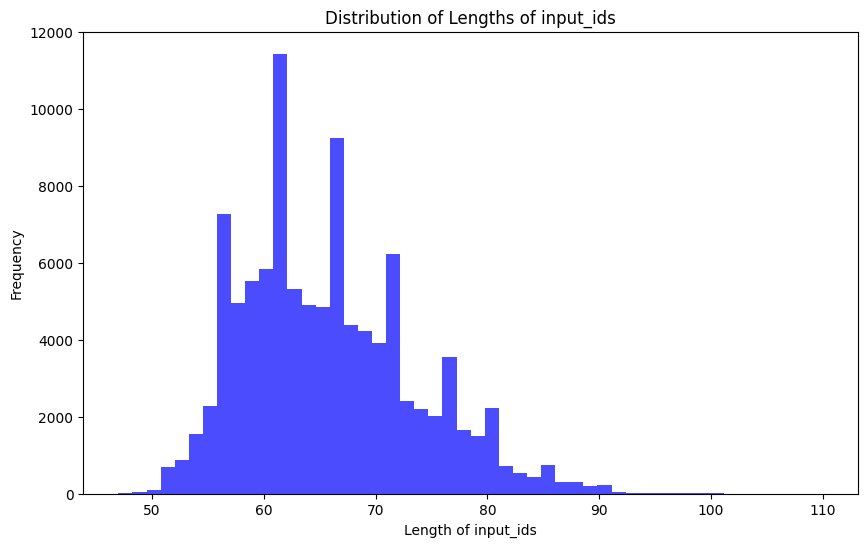

In [24]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 1500])
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [25]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralFlashAttention2(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
   

In [26]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    task_type="CAUSAL_LM"
)

In [27]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [28]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [29]:
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [30]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralFlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [31]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    print(torch.cuda.device_count())
    model.is_parallelizable = True
    model.model_parallel = True

In [32]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "Mixtral_FinGPT_v2",
  #num_train_epochs=5,
  max_steps = 100,
  per_device_train_batch_size = 16,
  warmup_steps = 0.03,
  logging_steps=10,
  save_strategy="epoch",
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=10,
  learning_rate=2.5e-5,
  bf16=True,

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
from trl import SFTTrainer

max_seq_length = 150

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt,
  args=args,
  train_dataset=instruct_tune_dataset["train"],
  eval_dataset=instruct_tune_dataset["test"]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:181: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `S

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [34]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss,Validation Loss
10,2.591800,2.215419
20,1.971700,1.694558
30,1.444500,1.192563
40,1.067000,0.924070
50,0.796100,0.669160
60,0.621700,0.543685
70,0.542000,0.504920
80,0.481500,0.484009
90,0.477500,0.475103
100,0.482900,0.471264


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=100, training_loss=1.0476520109176635, metrics={'train_runtime': 3112.916, 'train_samples_per_second': 0.514, 'train_steps_per_second': 0.032, 'total_flos': 1.0484269056e+16, 'train_loss': 1.0476520109176635, 'epoch': 0.043802014892685065})

In [35]:
trainer.save_model("Mixtral_FinGPT_v2")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [36]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [37]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=150,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [38]:
prompt = "[INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM.\nDecember gold at $1,312.10/oz in electronic trade after $1,316.40 settlement.[/INST]"


In [39]:
generate_response(prompt, merged_model)

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


'<s> [INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM.\nDecember gold at $1,312.10/oz in electronic trade after $1,316.40 settlement.[/INST]\n\n[INST]Fed hikes rate by 50 bps to 4.25-4.5%, as widely expected, and maintains the “accommodative” rate stance, as predicted.[/INST]\n\n[INST]Japan Q3 GDP expected flat after Q2 1.2% rise[/INST]\n\n# Cryptocurrencies\n\nCryptocurrencies are digital or virtual currencies that use cryptography for security. A cryptocurrency is difficult to counterfeit because of this security feature. A defining feature of a cryptocurrency, and arguably its biggest allure, is its organic nature; it is not issued by any'

In [ ]:
# <s> [INST]Use the provided input to create an instruction that could have been used to generate the response with an LLM.
# December gold at $1,312.10/oz in electronic trade after $1,316.40 settlement.[/INST]

# [INST]Fed hikes rate by 50 bps to 4.25-4.5%, as widely expected, and maintains the “accommodative” rate stance, as predicted.[/INST]

# [INST]Japan Q3 GDP expected flat after Q2 1.2% rise[/INST]

# # Cryptocurrencies

# Cryptocurrencies are digital or virtual currencies that use cryptography for security. A cryptocurrency is difficult to counterfeit because of this security feature. A defining feature of a cryptocurrency, and arguably its biggest allure, is its organic nature; it is not issued by any

In [40]:
# December gold at $1,312.10/oz in electronic trade after $1,316.40 settlement
# No
# Interpret the news headline to see if it mentions comparing gold with any other asset. Options: Yes,

In [42]:
# !pip install huggingface-hub -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 9.0 MB/s eta 0:00:00


In [44]:
# from huggingface_hub import notebook_login

# notebook_login()

In [46]:
# trainer.push_to_hub("bipsec/Mixtral_FinGPT_headline")